In [6]:
import skimage.io
import skimage.color
import cupy as cp
import time

# Função para replicar bordas (mirror padding)
def mirror(A, f):
    n, m = A.shape
    nlin = n + 2*f
    ncol = m + 2*f
    B = cp.zeros((nlin, ncol), dtype=A.dtype)
    B[f:nlin-f, f:ncol-f] = A
    B[0:f, 0:f] = cp.flip(A[0:f, 0:f])
    B[0:f, ncol-f:ncol] = cp.flip(A[0:f, m-f:m])
    B[nlin-f:nlin, 0:f] = cp.flip(A[n-f:n, 0:f])
    B[nlin-f:nlin, ncol-f:ncol] = cp.flip(A[n-f:n, m-f:m])
    B[0:f, f:ncol-f] = cp.flipud(A[0:f, :])
    B[nlin-f:nlin, f:ncol-f] = cp.flipud(A[n-f:n, :])
    B[f:nlin-f, 0:f] = cp.fliplr(A[:, 0:f])
    B[f:nlin-f, ncol-f:ncol] = cp.fliplr(A[:, m-f:m])
    return B

nlm_kernel_shared_code = r'''
extern "C" __global__
void nlm_kernel_shared(
    const float* img_n, float* output,
    int m, int n, int f, int t, float h, int padded_width
) {
    int i = blockIdx.y * blockDim.y + threadIdx.y;
    int j = blockIdx.x * blockDim.x + threadIdx.x;

    int Bx = blockDim.x;
    int By = blockDim.y;

    int pad = f + t;

    int sh_width = Bx + 2 * pad;
    int sh_height = By + 2 * pad;

    extern __shared__ float sh_img[];

    int base_i = blockIdx.y * blockDim.y + f - pad;
    int base_j = blockIdx.x * blockDim.x + f - pad;

    // Carrega patch expandido na shared memory
    for (int y = threadIdx.y; y < sh_height; y += By) {
        for (int x = threadIdx.x; x < sh_width; x += Bx) {
            int img_i = base_i + y;
            int img_j = base_j + x;

            // Replicação de borda
            int ii = img_i < 0 ? 0 : (img_i >= m + 2*f ? m + 2*f - 1 : img_i);
            int jj = img_j < 0 ? 0 : (img_j >= n + 2*f ? n + 2*f - 1 : img_j);

            sh_img[y * sh_width + x] = img_n[ii * padded_width + jj];
        }
    }
    __syncthreads();

    if (i >= m || j >= n) return;

    int local_i = threadIdx.y + pad;
    int local_j = threadIdx.x + pad;

    float NL = 0.0f;
    float Z = 0.0f;

    int rmin = max(local_i - t, pad);
    int rmax = min(local_i + t, By + pad - 1);
    int smin = max(local_j - t, pad);
    int smax = min(local_j + t, Bx + pad - 1);

    for (int r = rmin; r <= rmax; ++r) {
        for (int s = smin; s <= smax; ++s) {
            float d2 = 0.0f;
            for (int u = -f; u <= f; ++u) {
                for (int v = -f; v <= f; ++v) {
                    float diff = sh_img[(local_i + u) * sh_width + (local_j + v)] -
                                 sh_img[(r + u) * sh_width + (s + v)];
                    d2 += diff * diff;
                }
            }
            float sij = __expf(-d2 / (h * h));
            Z += sij;
            NL += sij * sh_img[r * sh_width + s];
        }
    }
    output[i * n + j] = NL / Z;
}
'''

def NLM_fast_cuda_shared(img, h, f, t):
    img = img.astype(cp.float32)
    m, n = img.shape
    padded = mirror(img, f)

    kernel_code = nlm_kernel_shared_code.encode('ascii', 'ignore').decode('ascii')
    module = cp.RawModule(code=kernel_code, options=('-std=c++11',))
    #module = cp.RawModule(code=nlm_kernel_shared_code, options=('-std=c++11',))
    kernel = module.get_function("nlm_kernel_shared")

    output = cp.zeros((m, n), dtype=cp.float32)

    threads_per_block = (16, 16)
    block_x = (n + threads_per_block[0] - 1) // threads_per_block[0]
    block_y = (m + threads_per_block[1] - 1) // threads_per_block[1]
    grid = (block_x, block_y)

    sh_width = threads_per_block[0] + 2 * (f + t)
    sh_height = threads_per_block[1] + 2 * (f + t)
    shared_mem_size = sh_width * sh_height * 4  # float32 = 4 bytes

    kernel(
        grid, threads_per_block,
        (
            padded.ravel(), output.ravel(),
            cp.int32(m), cp.int32(n), cp.int32(f), cp.int32(t),
            cp.float32(h), cp.int32(padded.shape[1])
        ),
        shared_mem=shared_mem_size
    )

    return output

# ------------------ TESTE --------------------

# img = skimage.io.imread('extras/images/ct2.png')
# if len(img.shape) > 2:
#     img = skimage.color.rgb2gray(img)
#     img = 255 * img
# img = cp.array(img).astype(cp.float32)

# h = 10.0
# f = 3
# t = 10

# start = time.time()
# result = NLM_fast_cuda_shared(img, h, f, t)
# cp.cuda.Stream.null.synchronize()  # espera terminar GPU
# print("Tempo GPU:", time.time()-start)


Tempo CPU: 8.8885817527771
Tempo GPU: 0.003926992416381836
Diferença média entre CPU e GPU: 0.05340209975838661
Diferença máxima entre CPU e GPU: 2.4076080322265625


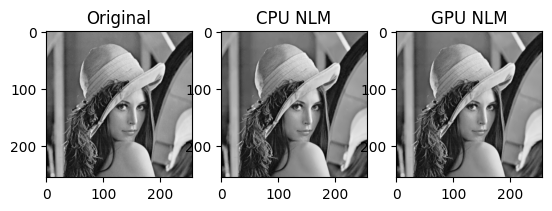

NameError: name 'result' is not defined

In [ ]:
import skimage.io
import skimage.color
import numpy as np
import cupy as cp
import time
from numba import njit
from skimage.transform import downscale_local_mean

# Função CPU original com njit (se já tiver, só copie)
@njit
def mirror_cpu(A, f):
    n, m = A.shape
    nlin = n + 2*f
    ncol = m + 2*f
    B = np.zeros((nlin, ncol), dtype=A.dtype)
    B[f:nlin-f, f:ncol-f] = A
    B[0:f, 0:f] = np.flip(A[0:f, 0:f])
    B[0:f, ncol-f:ncol] = np.flip(A[0:f, m-f:m])
    B[nlin-f:nlin, 0:f] = np.flip(A[n-f:n, 0:f])
    B[nlin-f:nlin, ncol-f:ncol] = np.flip(A[n-f:n, m-f:m])
    B[0:f, f:ncol-f] = np.flipud(A[0:f, :])
    B[nlin-f:nlin, f:ncol-f] = np.flipud(A[n-f:n, :])
    B[f:nlin-f, 0:f] = np.fliplr(A[:, 0:f])
    B[f:nlin-f, ncol-f:ncol] = np.fliplr(A[:, m-f:m])
    return B


# Função CUDA já dada no seu código, chamada NLM_fast_cuda_shared
# (deve estar definida no mesmo script)

# Carrega e prepara imagem
img_path = 'ProjetoDoutorado/wvc/images/0.gif'
img = skimage.io.imread(img_path)
img = img[0, :, :] if len(img.shape) > 2 else img

if len(img.shape) > 2:
    img = skimage.color.rgb2gray(img)
    img = 255 * img


img_downscale = downscale_local_mean(img, (2, 2))


img_cpu = np.array(img_downscale, dtype=np.float32)
img_gpu = cp.array(img_cpu)

h = 10.0
f = 4
t = 10

# Rodar CPU
start_cpu = time.time()


# Rodar GPU
start_gpu = time.time()
result_gpu = NLM_fast_cuda_shared(img_gpu, h, f, t)
cp.cuda.Stream.null.synchronize()  # Espera GPU terminar
print("Tempo GPU:", time.time() - start_gpu)

# Transferir resultado GPU para CPU para comparação
result_gpu_cpu = cp.asnumpy(result_gpu)

# Comparação das duas imagens filtradas


# Opcional: salvar imagens para visualização
import matplotlib.pyplot as plt
plt.subplot(1,3,1)
plt.title("Original")
plt.imshow(img_cpu, cmap='gray')
plt.subplot(1,3,2)
plt.title("CPU NLM")
plt.imshow(result_cpu, cmap='gray')
plt.subplot(1,3,3)
plt.title("GPU NLM")
plt.imshow(result_gpu_cpu, cmap='gray')
plt.show()


from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import numpy as np

# Converte para numpy antes de comparar
img_np = cp.asnumpy(img).astype(np.uint8)
result_np = cp.asnumpy(result).astype(np.uint8)

# Calcula PSNR
psnr = peak_signal_noise_ratio(img_np, result_np)
print('PSNR (NLM CUDA): %f' % psnr)

# Calcula SSIM
ssim = structural_similarity(img_np, result_np)
print('SSIM (NLM CUDA): %f' % ssim)


In [32]:
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import numpy as np

# Certifique-se de que as imagens estão no formato uint8 para o cálculo correto
original_uint8 = img_cpu.astype(np.uint8)
cpu_result_uint8 = result_cpu.astype(np.uint8)
gpu_result_uint8 = result_gpu_cpu.astype(np.uint8)

# PSNR e SSIM da CPU
psnr_cpu = peak_signal_noise_ratio(original_uint8, cpu_result_uint8)
ssim_cpu = structural_similarity(original_uint8, cpu_result_uint8)
print('PSNR (NLM CPU): %f' % psnr_cpu)
print('SSIM (NLM CPU): %f' % ssim_cpu)

# PSNR e SSIM da GPU
psnr_gpu = peak_signal_noise_ratio(original_uint8, gpu_result_uint8)
ssim_gpu = structural_similarity(original_uint8, gpu_result_uint8)
print('PSNR (NLM GPU): %f' % psnr_gpu)
print('SSIM (NLM GPU): %f' % ssim_gpu)

# Comparando CPU e GPU entre si
psnr_diff = peak_signal_noise_ratio(cpu_result_uint8, gpu_result_uint8)
ssim_diff = structural_similarity(cpu_result_uint8, gpu_result_uint8)
print('PSNR (CPU vs GPU): %f' % psnr_diff)
print('SSIM (CPU vs GPU): %f' % ssim_diff)


PSNR (NLM CPU): 61.591842
SSIM (NLM CPU): 0.999803
PSNR (NLM GPU): 61.074503
SSIM (NLM GPU): 0.999773
PSNR (CPU vs GPU): 64.504807
SSIM (CPU vs GPU): 0.999859



Comparações com a imagem original:
NLM CPU → PSNR: 57.65 dB, SSIM: 0.999532
NLM GPU → PSNR: 57.47 dB, SSIM: 0.999502
OpenCV fastNLM → PSNR: 33.88 dB, SSIM: 0.846741

Comparações entre métodos:
CPU vs GPU → PSNR: 64.50 dB, SSIM: 0.999859
CPU vs OpenCV → PSNR: 33.88 dB, SSIM: 0.846821
GPU vs OpenCV → PSNR: 33.87 dB, SSIM: 0.846639


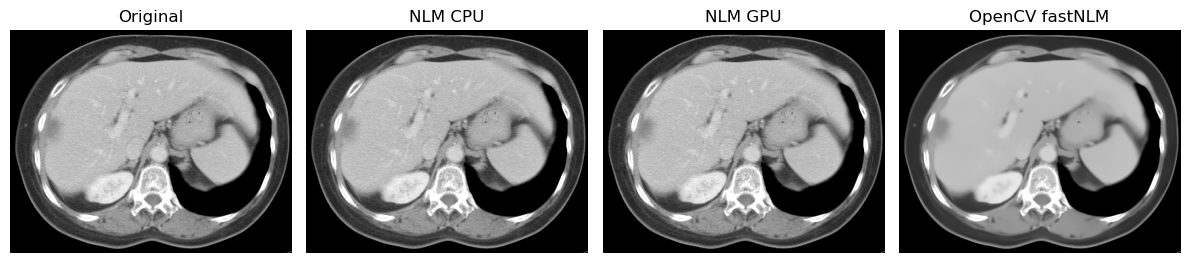

In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

# Carregar imagem original e garantir escala de cinza
img = imread('extras/images/ct2.png')
if len(img.shape) > 2:
    img = rgb2gray(img)
img = (255 * img).astype(np.uint8)

# Aplicar filtro do OpenCV
# h = 10 → parâmetro de filtragem (equivalente ao seu)
# templateWindowSize = 2*f + 1 → tamanho do patch
# searchWindowSize = 2*t + 1 → tamanho da janela de busca
h_cv = 10
f = 3
t = 10
templateWindowSize = 2 * f + 1
searchWindowSize = 2 * t + 1

result_cv2 = cv2.fastNlMeansDenoising(img, None, h=h_cv, templateWindowSize=templateWindowSize, searchWindowSize=searchWindowSize)

# --- Seus resultados anteriores ---
# Você já tem result_cpu e result_gpu_cpu
result_cpu_uint8 = np.clip(result_cpu, 0, 255).astype(np.uint8)
result_gpu_uint8 = np.clip(result_gpu_cpu, 0, 255).astype(np.uint8)

# Comparações
def comparar(ref, test, nome):
    psnr = peak_signal_noise_ratio(ref, test)
    ssim = structural_similarity(ref, test)
    print(f'{nome} → PSNR: {psnr:.2f} dB, SSIM: {ssim:.6f}')
    return psnr, ssim

print("\nComparações com a imagem original:")
comparar(img, result_cpu_uint8, "NLM CPU")
comparar(img, result_gpu_uint8, "NLM GPU")
comparar(img, result_cv2, "OpenCV fastNLM")

# Comparação entre métodos
print("\nComparações entre métodos:")
comparar(result_cpu_uint8, result_gpu_uint8, "CPU vs GPU")
comparar(result_cpu_uint8, result_cv2, "CPU vs OpenCV")
comparar(result_gpu_uint8, result_cv2, "GPU vs OpenCV")

# Mostrar visualmente
plt.figure(figsize=(12, 4))
plt.subplot(1, 4, 1)
plt.imshow(img, cmap='gray')
plt.title("Original")
plt.axis("off")

plt.subplot(1, 4, 2)
plt.imshow(result_cpu_uint8, cmap='gray')
plt.title("NLM CPU")
plt.axis("off")

plt.subplot(1, 4, 3)
plt.imshow(result_gpu_uint8, cmap='gray')
plt.title("NLM GPU")
plt.axis("off")

plt.subplot(1, 4, 4)
plt.imshow(result_cv2, cmap='gray')
plt.title("OpenCV fastNLM")
plt.axis("off")

plt.tight_layout()
plt.show()
